In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow-datasets librosa soundfile


In [3]:
import zipfile

# Define paths
speech_zip_path = '/content/drive/MyDrive/RAVDESS/Audio_Speech_Actors_01-24.zip'
extract_path = '/content/RAVDESS/Speech'

# Extract the dataset
with zipfile.ZipFile(speech_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Data Preprocessing and TensorFlow Dataset Creation


In [4]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display

In [5]:
# Mapping of emotion identifiers to their corresponding labels
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Function to extract features from audio files and pad/truncate to a fixed length
def extract_features(audio, sr=22050, feature_type='mfcc', num_features=40, delta=False, max_pad_len=862):
    if len(audio) == 0:
        print("Empty audio signal encountered.")
        return None

    try:
        if feature_type == 'mfcc':
            features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_features)
        elif feature_type == 'mel':
            features = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=num_features)
        elif feature_type == 'stft':
            features = np.abs(librosa.stft(y=audio, n_fft=512))

        if delta:
            delta_feat = librosa.feature.delta(features)
            delta_delta_feat = librosa.feature.delta(features, order=2)
            features = np.concatenate((features, delta_feat, delta_delta_feat), axis=0)

        # Clip features to avoid overflow
        features = np.clip(features, a_min=-1e10, a_max=1e10)

        # Pad or truncate to the fixed length
        if features.shape[1] > max_pad_len:
            features = features[:, :max_pad_len]
        else:
            pad_width = max_pad_len - features.shape[1]
            features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')

        # Check for NaN values and replace them with zero
        features = np.nan_to_num(features)

        return features
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Load dataset and extract features
def load_data(dataset_path, feature_type='mfcc', num_features=40, delta=False, max_pad_len=862):
    features_list, labels_list, file_paths_list = [], [], []
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                label = file.split('-')[2]  # Extract emotion label from filename
                try:
                    audio, sr = librosa.load(file_path, sr=None)
                    if len(audio) == 0:
                        print(f'Empty audio file: {file_path}')
                        continue
                    features = extract_features(audio, sr=sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=max_pad_len)
                    if features is not None and features.shape[1] > 0:  # Check for valid features
                        features_list.append(features)
                        labels_list.append(label)
                        file_paths_list.append(file_path)
                except Exception as e:
                    print(f'Error processing {file_path}: {e}')
    return np.array(features_list), np.array(labels_list), file_paths_list

# Function to plot a spectrogram
def plot_spectrogram(spectrogram, label, sr=22050):
    plt.figure(figsize=(10, 4))
    if spectrogram.ndim == 2:
        plt.imshow(librosa.power_to_db(spectrogram, ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    elif spectrogram.ndim == 3:
        plt.imshow(librosa.power_to_db(spectrogram[:, :, 0], ref=np.max), aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Label: {label}')
    plt.ylabel('Frequency bins')
    plt.xlabel('Time frames')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Function to play and plot the spectrogram of a sample
def check_audio_sample(X, y, index, label_encoder, sr=22050, audio_files=None):
    num_features = 40  # Define the number of features used
    sample = X[index].squeeze(axis=0)  # Remove single-dimensional entries from the shape
    label = label_encoder.inverse_transform([y[index]])[0]
    emotion = emotion_map.get(label, 'Unknown')  # Map label to emotion

    print(f'Emotion: {emotion}')
    print(f'Sample shape: {sample.shape}')

    # Plot the spectrogram
    plot_spectrogram(sample, emotion)

    # Play the audio file if available
    if audio_files:
        audio_path = audio_files[index]
        audio_data, _ = librosa.load(audio_path, sr=sr)
        return Audio(audio_data, rate=sr)

    return None



In [6]:
import numpy as np
import librosa
import random

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=2, shift_direction='both'):
    shift = np.random.randint(shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = random.choice([-1, 1])
        shift = shift * direction
    augmented_audio = np.roll(audio, shift)
    return augmented_audio

def pitch_shift(audio, sr, pitch_factor=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=pitch_factor)

def time_stretch(audio, stretch_factor=0.8):
    return librosa.effects.time_stretch(y=audio, rate=stretch_factor)


def load_data(dataset_path, feature_type='mfcc', num_features=40, delta=False, max_pad_len=862, augment=False):
    features_list, labels_list, file_paths_list = [], [], []
    for subdir, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                label = file.split('-')[2]  # Extract emotion label from filename
                try:
                    audio, sr = librosa.load(file_path, sr=None)
                    if len(audio) == 0:
                        print(f'Empty audio file: {file_path}')
                        continue

                    if augment:
                        augmented_audio = audio
                        if random.random() < 0.3:
                            augmented_audio = add_noise(audio)
                        if random.random() < 0.3:
                            augmented_audio = time_shift(augmented_audio)
                        if random.random() < 0.3:
                            augmented_audio = pitch_shift(augmented_audio, sr)
                        if random.random() < 0.3:
                            augmented_audio = time_stretch(augmented_audio)

                        features = extract_features(augmented_audio, sr=sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=max_pad_len)
                    else:
                        features = extract_features(audio, sr=sr, feature_type=feature_type, num_features=num_features, delta=delta, max_pad_len=max_pad_len)

                    if features is not None and features.shape[1] > 0:  # Check for valid features
                        features_list.append(features)
                        labels_list.append(label)
                        file_paths_list.append(file_path)
                except Exception as e:
                    print(f'Error processing {file_path}: {e}')
    return np.array(features_list), np.array(labels_list), file_paths_list


In [7]:
# Extract features and labels with augmentation
X, y, file_paths = load_data('/content/RAVDESS/Speech', feature_type='mfcc', num_features=40, delta=True, augment=True)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Add a new axis to the features to match the expected input shape for Conv2D
X = X[..., np.newaxis]

# Expand dimensions to match the expected shape of the CNN-LSTM model
X = np.expand_dims(X, axis=1)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp, file_paths_train, file_paths_temp = train_test_split(X, y_encoded, file_paths, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, file_paths_val, file_paths_test = train_test_split(X_temp, y_temp, file_paths_temp, test_size=0.5, random_state=42)

# Print shapes
print('Train data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)




Train data shape: (1008, 1, 120, 862, 1) (1008,)
Validation data shape: (216, 1, 120, 862, 1) (216,)
Test data shape: (216, 1, 120, 862, 1) (216,)


neutral: 65
calm: 132
happy: 130
sad: 126
angry: 143
fearful: 131
disgust: 140
surprised: 141


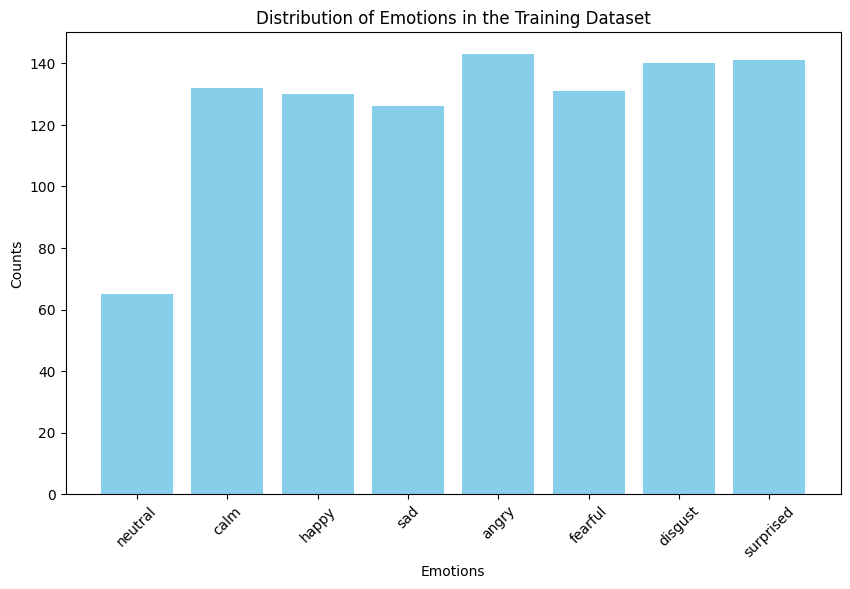

In [8]:
# Mapping of emotion identifiers to their corresponding labels
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def plot_label_distribution(y, label_encoder):
    # Decode the labels to get human-readable label names
    labels = label_encoder.inverse_transform(np.unique(y))
    counts = np.bincount(y)

    # Map encoded labels to emotion names
    emotion_labels = [emotion_map[label] for label in labels]

    # Print the counts of each label
    for emotion, count in zip(emotion_labels, counts):
        print(f'{emotion}: {count}')

    plt.figure(figsize=(10, 6))
    plt.bar(emotion_labels, counts, color='skyblue')
    plt.xlabel('Emotions')
    plt.ylabel('Counts')
    plt.title('Distribution of Emotions in the Training Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Plot label distribution for the training dataset
plot_label_distribution(y_train, label_encoder)

In [9]:
from sklearn.utils import resample

def balance_dataset(X, y):
    unique_classes = np.unique(y)
    max_samples = max([np.sum(y == cls) for cls in unique_classes])

    X_balanced = []
    y_balanced = []

    for cls in unique_classes:
        X_class = X[y == cls]
        y_class = y[y == cls]
        X_resampled, y_resampled = resample(X_class, y_class, replace=True, n_samples=max_samples, random_state=42)
        X_balanced.append(X_resampled)
        y_balanced.append(y_resampled)

    X_balanced = np.concatenate(X_balanced)
    y_balanced = np.concatenate(y_balanced)

    return X_balanced, y_balanced

# Balance the training dataset
X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)



In [10]:
# Print shapes
print('Train data shape:', X_train_balanced.shape, y_train_balanced.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

Train data shape: (1144, 1, 120, 862, 1) (1144,)
Validation data shape: (216, 1, 120, 862, 1) (216,)
Test data shape: (216, 1, 120, 862, 1) (216,)


neutral: 143
calm: 143
happy: 143
sad: 143
angry: 143
fearful: 143
disgust: 143
surprised: 143


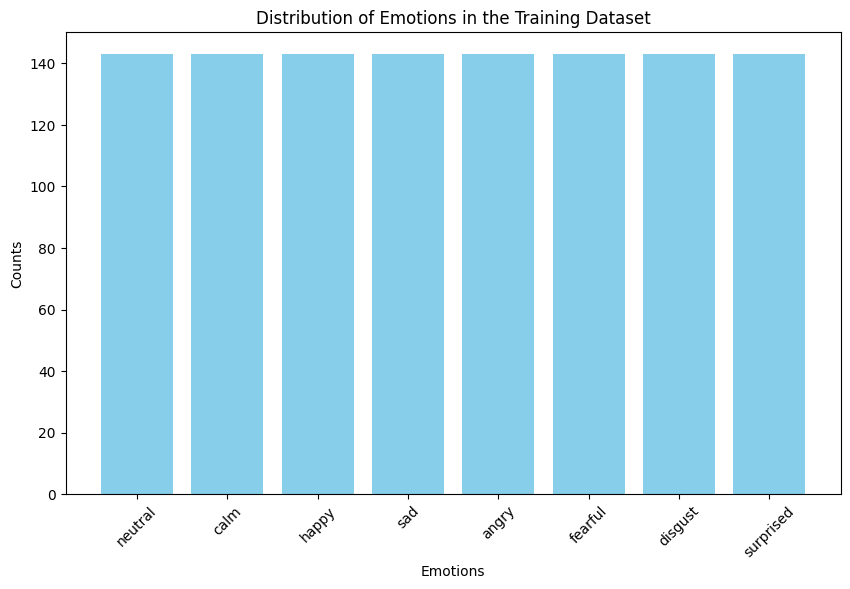

In [11]:
# Plot label distribution for the training dataset
plot_label_distribution(y_train_balanced, label_encoder)

Training sample index 0 visualization:
Emotion: happy
Sample shape: (120, 862, 1)


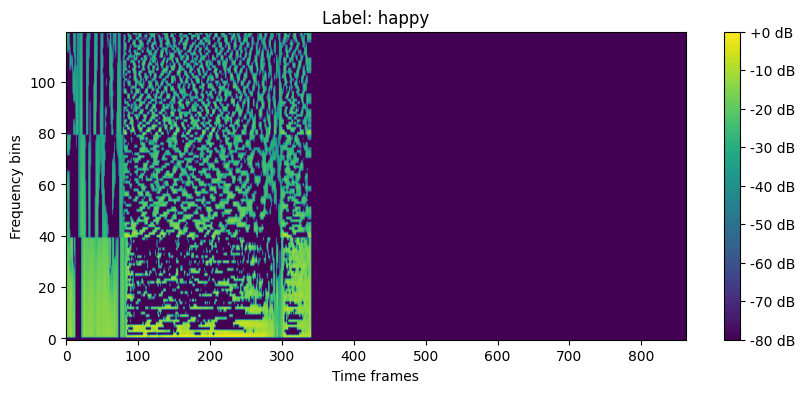

Validation sample index 0 visualization:
Emotion: fearful
Sample shape: (120, 862, 1)


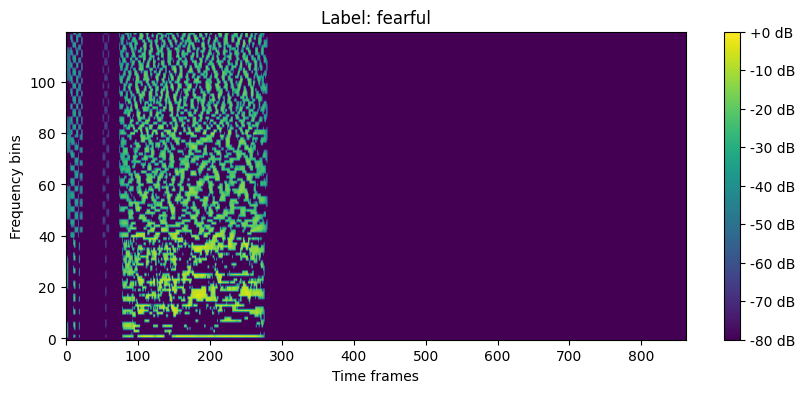

Test sample index 0 visualization:
Emotion: happy
Sample shape: (120, 862, 1)


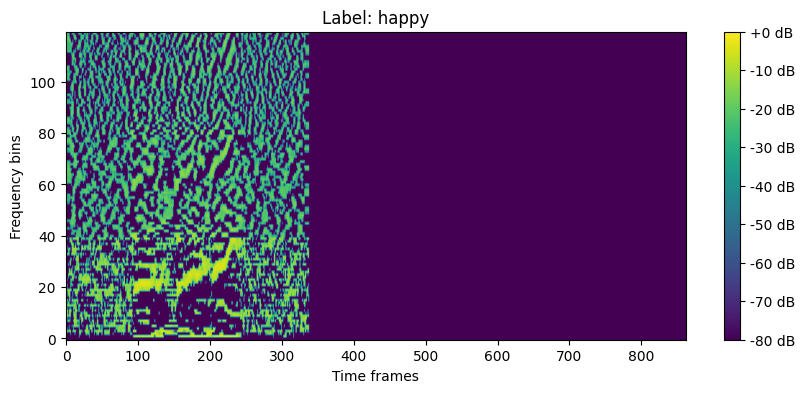

In [12]:
# Example usage
sample_index = 0  # Change this index to visualize different samples

print(f'Training sample index {sample_index} visualization:')
audio_train = check_audio_sample(X_train, y_train, sample_index, label_encoder, audio_files=file_paths_train)
if audio_train:
    display(audio_train)

print(f'Validation sample index {sample_index} visualization:')
audio_val = check_audio_sample(X_val, y_val, sample_index, label_encoder, audio_files=file_paths_val)
if audio_val:
    display(audio_val)

print(f'Test sample index {sample_index} visualization:')
audio_test = check_audio_sample(X_test, y_test, sample_index, label_encoder, audio_files=file_paths_test)
if audio_test:
    display(audio_test)


# Build Model

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, LSTM, MaxPooling2D, Dropout, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD
import numpy as np

def assign_model_settings(num_labels, sparse_targets):
    if num_labels <= 2:
        loss_type = 'binary_crossentropy'
        activation_output = 'sigmoid'
    else:
        loss_type = 'categorical_crossentropy'
        activation_output = 'softmax'
    if sparse_targets:
        loss_type = 'sparse_categorical_crossentropy'
    return loss_type, activation_output

def buildmodel(model_type, num_labels, frame_width, timesteps, num_features, color_scale, lstm_cells, feature_map_filters, kernel_size, pool_size, dense_hidden_units, activation_output):
    if model_type.lower() == 'lstm':
        model = Sequential()
        model.add(LSTM(lstm_cells, return_sequences=True, input_shape=(frame_width, num_features)))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))  # Dropout after first LSTM layer
        model.add(LSTM(lstm_cells, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))  # Dropout after second LSTM layer
    elif model_type.lower() == 'cnn':
        model = Sequential()
        model.add(Conv2D(feature_map_filters, kernel_size=kernel_size, activation='relu', input_shape=(frame_width * timesteps, num_features, color_scale)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(dense_hidden_units, activation='relu'))

    elif model_type.lower() == 'cnnlstm':
        cnn = Sequential()
        cnn.add(Conv2D(feature_map_filters, kernel_size=kernel_size, activation='relu', input_shape=(frame_width, num_features, color_scale)))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=pool_size))
        cnn.add(Dropout(0.25))
        cnn.add(Conv2D(feature_map_filters, kernel_size=kernel_size, activation='relu'))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=pool_size))
        cnn.add(Dropout(0.25))
        cnn.add(Conv2D(feature_map_filters, kernel_size=kernel_size, activation='relu'))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=pool_size))
        cnn.add(Dropout(0.25))
        cnn.add(Flatten())

        model = Sequential()
        model.add(TimeDistributed(cnn, input_shape=(timesteps, frame_width, num_features, color_scale)))
        model.add(LSTM(lstm_cells, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))  # Dropout after first LSTM layer
        model.add(LSTM(lstm_cells, return_sequences=True))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))  # Dropout after second LSTM layer


    model.add(Flatten())
    model.add(Dense(dense_hidden_units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation=activation_output))
    return model

# Train Model

In [66]:
# Model settings
num_labels = len(np.unique(y_train))
loss_type, activation_output = assign_model_settings(num_labels, sparse_targets=True)
frame_width = X_train.shape[2]
timesteps = X_train.shape[1]  # Should be 1 after reshaping
num_features = X_train.shape[3]
color_scale = 1
lstm_cells = 96
feature_map_filters = 256
kernel_size = (3, 3)
pool_size = (2, 2)
dense_hidden_units = 128

# Adjust the learning rate
learning_rate = 0.001

# Build the model
model = buildmodel('cnnlstm', num_labels, frame_width, timesteps, num_features, color_scale, lstm_cells, feature_map_filters, kernel_size, pool_size, dense_hidden_units, activation_output)
optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_type, metrics=['accuracy'])

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, callbacks=[early_stop])

Epoch 1/20
63/63 [==============================] - 14s 161ms/step - loss: 2.3045 - accuracy: 0.1141 - val_loss: 2.0815 - val_accuracy: 0.1389
Epoch 2/20
63/63 [==============================] - 9s 137ms/step - loss: 2.0925 - accuracy: 0.1220 - val_loss: 2.0815 - val_accuracy: 0.1343
Epoch 3/20
63/63 [==============================] - 9s 136ms/step - loss: 2.0820 - accuracy: 0.1508 - val_loss: 2.0812 - val_accuracy: 0.1343
Epoch 4/20
63/63 [==============================] - 9s 136ms/step - loss: 2.0825 - accuracy: 0.1349 - val_loss: 2.0808 - val_accuracy: 0.1343
Epoch 5/20
63/63 [==============================] - 9s 135ms/step - loss: 2.0772 - accuracy: 0.1448 - val_loss: 2.0801 - val_accuracy: 0.1343
Epoch 6/20
63/63 [==============================] - 9s 136ms/step - loss: 2.0810 - accuracy: 0.1319 - val_loss: 2.0793 - val_accuracy: 0.1435
Epoch 7/20
63/63 [==============================] - 8s 131ms/step - loss: 2.0796 - accuracy: 0.1270 - val_loss: 2.0796 - val_accuracy: 0.1389
Epoch

**Why Use CNN-LSTM for Audio Data** <br/>
1.Feature Extraction with CNN: <br/>
-Spectrogram Conversion: Audio data is inherently a one-dimensional signal over time. To extract meaningful patterns, we often convert it into a 2D representation called a spectrogram. A spectrogram is a visual representation of the spectrum of frequencies in a sound signal as they vary with time. This is done using techniques like Short-Time Fourier Transform (STFT) or Mel-Frequency Cepstral Coefficients (MFCC) <br/>
-CNN for Feature Extraction: Convolutional Neural Networks (CNNs) excel at detecting spatial patterns in 2D data. When applied to spectrograms, CNNs can detect features such as edges, shapes, and textures that correspond to different sound characteristics and frequencies over time. These detected features can be crucial for identifying emotions expressed in the audio <br/>
2.Temporal Dynamics with LSTM: <br/>
Sequential Nature of Audio: Emotions in audio are expressed not just in isolated sounds but in how these sounds change over time. Capturing these temporal dynamics is essential for accurate emotion classification <br/>
LSTM for Temporal Modeling: Long Short-Term Memory (LSTM) networks are designed to handle sequential data and can capture long-term dependencies. After CNNs extract spatial features from each time slice of the spectrogram, LSTMs can analyze the sequence of these features to understand how they evolve over time. This helps in identifying the temporal patterns associated with different emotions <br/>
**How to Apply CNN-LSTM to Audio Data** <br/>
Here's a step-by-step explanation of the process: <br/>
1.Convert Audio to Spectrogram: <br/>
Audio Preprocessing: First, the audio data is preprocessed, which may include noise reduction, normalization, and segmentation <br/>
Spectrogram Generation: The preprocessed audio is then converted into a spectrogram. This involves breaking the audio into short overlapping segments and computing the frequency spectrum for each segment. The result is a 2D representation where one axis represents time and the other represents frequency, and the intensity of each point represents the amplitude of a specific frequency at a specific time <br/>
2.Apply CNN for Feature Extraction: <br/>
Convolutional Layers: The spectrogram is fed into a series of convolutional layers. These layers apply convolutional filters to detect local patterns in the time-frequency domain. Each filter can capture different features, such as frequency bands, harmonics, or pitch variations <br/>
Pooling Layers: Pooling layers are used to downsample the feature maps, reducing the dimensionality and focusing on the most important features <br/>
Dropout Layers: Dropout layers are included to prevent overfitting by randomly setting a fraction of the input units to zero during training.
Flattening: The final output of the CNN layers is a flattened feature vector that represents the spatial features extracted from the spectrogram.
3.Apply LSTM for Temporal Modeling: <br/>
TimeDistributed Wrapper: To apply CNN to each time step independently, the spectrogram can be divided into smaller overlapping time windows. The TimeDistributed wrapper ensures that the CNN processes each time window independently, producing a sequence of feature vectors.
LSTM Layers: These sequences of feature vectors are then fed into LSTM layers. The LSTM layers analyze the temporal sequence of these features, capturing how they change over time. This is crucial for understanding the temporal dynamics of the audio signal and for classifying the emotion based on these dynamics.
Output Layer: Finally, the LSTM's output is passed through a dense layer with a softmax or sigmoid activation function to produce the emotion classification <br/>
**Summary** <br/>
CNN extracts spatial features from each time slice of the spectrogram.
LSTM captures temporal dependencies between these features.
TimeDistributed ensures CNN is applied to each time step independently before passing the sequence of feature vectors to LSTM.

# Model Evaluation

7/7 [==============================] - 0s 13ms/step - loss: 2.0625 - accuracy: 0.1111
Test Loss: 2.0625064373016357, Test Accuracy: 0.1111111119389534


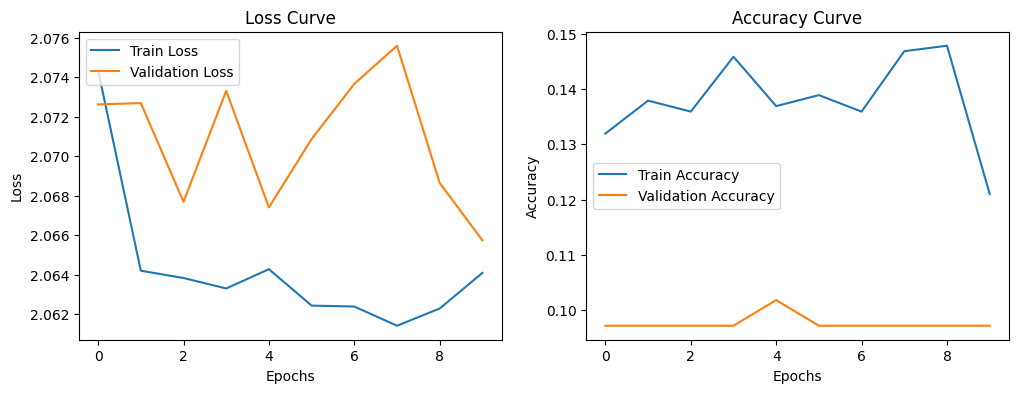

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/speech_emotion_model.h5')

# Make Predictions

In [ ]:
def predict_emotion_from_features(features, model, label_encoder):
    if features is not None:
        # Reshape the features to match the model input
        features = features[..., np.newaxis]  # Add channel dimension
        features = np.expand_dims(features, axis=0)  # Add batch dimension
        features = np.expand_dims(features, axis=1)  # Add time step dimension

        # Make prediction
        prediction = model.predict(features)

        # Decode the predicted label
        predicted_label = np.argmax(prediction, axis=1)
        predicted_emotion = label_encoder.inverse_transform(predicted_label)[0]

        return emotion_map.get(predicted_emotion, 'Unknown')
    else:
        return None


In [ ]:
# Load the trained model
model_path = 'model.h5'  # Path to the saved model
model = load_model(model_path)  # Load the trained model

# Assuming label_encoder is already created and fitted
# If not, you need to fit the label_encoder with the training labels again
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Select an index from the test set
test_index = 0  # Change this index to select different samples

# Get the features and label for the selected test sample
test_features = X_test[test_index]
test_label = y_test[test_index]

# Predict the emotion of the test sample
predicted_emotion = predict_emotion_from_features(test_features, model, label_encoder)
actual_emotion = emotion_map.get(label_encoder.inverse_transform([test_label])[0], 'Unknown')

print(f'Actual Emotion: {actual_emotion}')
print(f'Predicted Emotion: {predicted_emotion}')

# Optionally, play the audio file
test_audio_path = file_paths_test[test_index]
audio_data, sr = librosa.load(test_audio_path, sr=None)
display(Audio(audio_data, rate=sr))
